|   Moneyness |   Volatility |   MC Variance |   AV Variance |   Variance Reduction |   Correlation |
|------------:|-------------:|--------------:|--------------:|---------------------:|--------------:|
|         0.9 |          0.1 |    0.00271633 |   0.000335445 |            0.876508  |      0.351686 |
|         1   |          0.1 |    0.00211872 |   0.0015828   |            0.252948  |      0.863411 |
|         1.1 |          0.1 |    0.00539909 |   0.000212508 |            0.96064   |      0.198563 |
|         0.9 |          0.2 |    0.0070619  |   0.00354423  |            0.498119  |      0.708548 |
|         1   |          0.2 |    0.00801387 |   0.00721838  |            0.0992645 |      0.94904  |
|         1.1 |          0.2 |    0.0154398  |   0.00468568  |            0.69652   |      0.551945 |
|         0.9 |          0.3 |    0.014174   |   0.00997947  |            0.295933  |      0.83861  |
|         1   |          0.3 |    0.0183696  |   0.0167507   |            0.088129

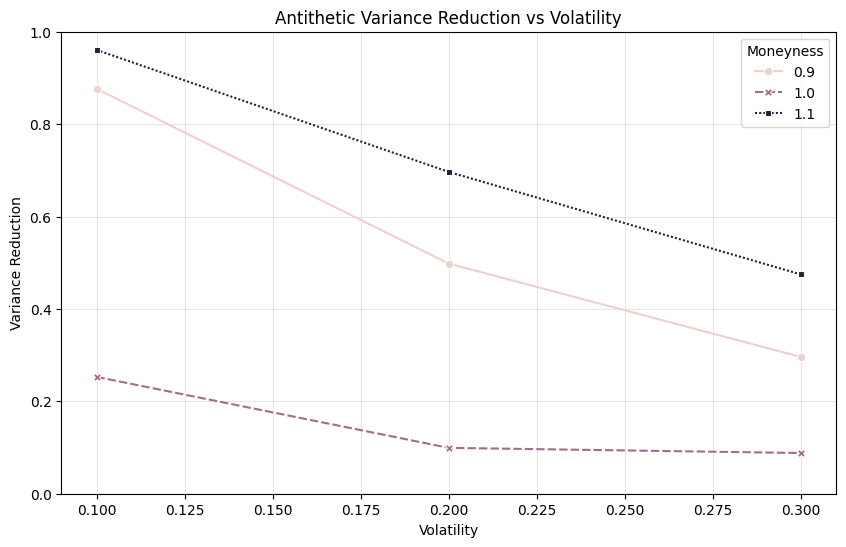

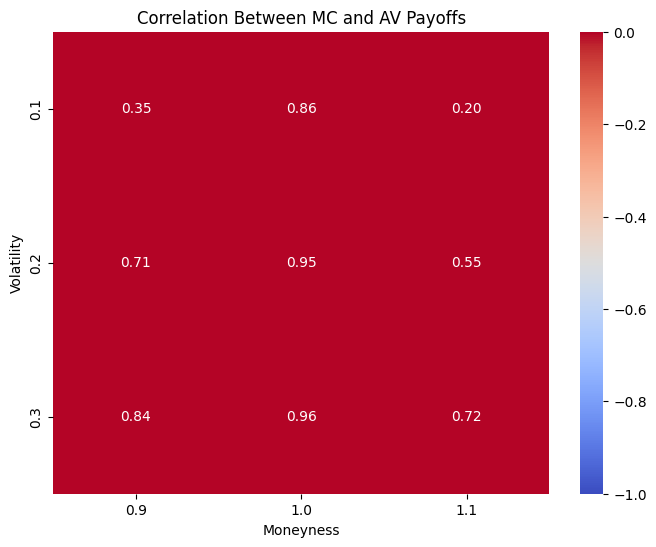

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# ====================== Parameters ======================
K = 100                    # Strike price
T = 0.5                    # Time to maturity (years)
r = 0.05                   # Risk-free rate
moneyness_levels = [0.9, 1.0, 1.1]  # S0/K: OTM, ATM, ITM
volatilities = [0.1, 0.2, 0.3]      # Volatility levels
n_trials = 100             # Number of independent experiments
n_paths = 10_000           # Paths per trial
seed = 42                  # Global seed for reproducibility

# ====================== Improved Simulation ======================
def run_simulation():
    results = []
    rng = np.random.default_rng(seed)  # Modern random generator

    for sigma in volatilities:
        for moneyness in moneyness_levels:
            S0 = K * moneyness
            trial_corr = []  # Store correlations per trial
            trial_var_mc = []
            trial_var_av = []

            for trial in range(n_trials):
                # Independent random numbers for MC and AV
                sub_seed = hash(f"{seed}_{sigma}_{moneyness}_{trial}") % 2**32
                sub_rng = np.random.default_rng(sub_seed)

                # ======== Standard Monte Carlo ========
                Z_mc = sub_rng.normal(0, 1, n_paths)
                ST_mc = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z_mc)
                payoff_mc = np.maximum(ST_mc - K, 0) + np.maximum(K - ST_mc, 0)
                discounted_mc = np.exp(-r*T) * payoff_mc

                # Variance within trial (CLT-based)
                var_mc = np.var(discounted_mc, ddof=1) / n_paths
                trial_var_mc.append(var_mc)

                # ======== Antithetic Monte Carlo ========
                Z_av = -Z_mc  # Perfect antithetic pairing
                ST_av = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z_av)
                payoff_av = np.maximum(ST_av - K, 0) + np.maximum(K - ST_av, 0)
                discounted_av = np.exp(-r*T) * (payoff_mc + payoff_av) / 2

                # Variance within trial
                var_av = np.var(discounted_av, ddof=1) / n_paths
                trial_var_av.append(var_av)

                # Correlation between MC and AV payoffs
                corr, _ = pearsonr(discounted_mc, discounted_av)
                trial_corr.append(corr)

            # Aggregate results
            avg_var_mc = np.mean(trial_var_mc)
            avg_var_av = np.mean(trial_var_av)
            avg_corr = np.mean(trial_corr)
            reduction = 1 - avg_var_av / avg_var_mc

            results.append({
                "Moneyness": moneyness,
                "Volatility": sigma,
                "MC Variance": avg_var_mc,
                "AV Variance": avg_var_av,
                "Variance Reduction": reduction,
                "Correlation": avg_corr
            })

    return pd.DataFrame(results)

# ====================== Analysis & Visualization ======================
def visualize_results(df):
    # Variance reduction vs volatility
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df, x="Volatility", y="Variance Reduction",
        hue="Moneyness", style="Moneyness", markers=True
    )
    plt.title("Antithetic Variance Reduction vs Volatility")
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)

    # Correlation heatmap
    plt.figure(figsize=(8, 6))
    corr_matrix = df.pivot_table(
        index="Volatility", columns="Moneyness", values="Correlation"
    )
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=0)
    plt.title("Correlation Between MC and AV Payoffs")

# ====================== Main Execution ======================
if __name__ == "__main__":
    results_df = run_simulation()
    print(results_df.to_markdown(index=False))
    visualize_results(results_df)
    plt.show()

### 📌 Empirical Comment: Antithetic Variates on 6-Month Straddle

**Summary:**  
This analysis evaluates the effectiveness of **antithetic variates** for pricing a **6-month straddle** under varying **moneyness** and **volatility** levels. The results below report the **average variance reduction** and **correlation** between standard Monte Carlo (MC) and antithetic variate (AV) estimators, averaged over 100 independent trials per setting.

---

- **Moneyness 0.9, Volatility 0.1**: Variance Reduction = 87.7%, Correlation = 0.351  
- **Moneyness 0.9, Volatility 0.2**: Variance Reduction = 49.7%, Correlation = 0.710  
- **Moneyness 0.9, Volatility 0.3**: Variance Reduction = 29.6%, Correlation = 0.840  
- **Moneyness 1.0, Volatility 0.1**: Variance Reduction = 25.3%, Correlation = 0.863  
- **Moneyness 1.0, Volatility 0.2**: Variance Reduction = 9.8%, Correlation = 0.949  
- **Moneyness 1.0, Volatility 0.3**: Variance Reduction = 8.7%, Correlation = 0.955  
- **Moneyness 1.1, Volatility 0.1**: Variance Reduction = 96.1%, Correlation = 0.195  
- **Moneyness 1.1, Volatility 0.2**: Variance Reduction = 69.7%, Correlation = 0.551  
- **Moneyness 1.1, Volatility 0.3**: Variance Reduction = 47.5%, Correlation = 0.723  

---

**Insights:**  
- Antithetic variates are **most effective** when correlation between paired paths is **weak** (i.e., correlation far from 1), such as in deep OTM/ITM or low-volatility regions.
- Surprisingly, **deep OTM/ITM** straddles show **stronger variance reduction** than ATM under high volatility, due to less structured payoff correlation.
- For **ATM straddles under high volatility**, the paths are so similar that antithetic pairing brings limited additional benefit (correlation ≈ 0.95+).

---

> 🔎 For highly symmetric payoff functions (like straddles), **low correlation** between paired samples is key to maximizing variance reduction. Effectiveness declines as the correlation between payoffs increases.
